In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K
mse = tf.keras.losses.MeanSquaredError()

from MD_AE_tools.models.models import *
# from MD_AE_tools.models.models_no_bias import *
import myplot
import MD_AE_tools.mode_decomposition as md

import h5py
import numpy as np
import matplotlib.pyplot as plt
import configparser

config = configparser.ConfigParser()
config.read('~system.ini')
system_info = config['system_info']

2022-05-19 15:34:45.745638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 15:34:45.745663: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
## import data
results_folder = 'Hierarchical_10_1__2022_05_10__13_01_10'
folder = system_info['save_location'] + '/' + results_folder + '/'
filename = folder + 'results.h5'
hf = h5py.File(filename,'r')
u_test = np.array(hf.get('u_test'))
hist_train = np.array(hf.get('hist_train'))
hist_val = np.array(hf.get('hist_val'))
u_avg = np.array(hf.get('u_avg'))
latent_test = np.array(hf.get('latent_test')) # shape [latent_variable, test_snapshots, 1]
y_test = np.array(hf.get('y_test')) # [modes,nt,ny,nz,nu]
hf.close()

latent_test = np.squeeze(latent_test).T # shape [snapshots, latent_variable]

In [4]:
filename = folder + 'Model_param.h5'
hf = h5py.File(filename,'r')
Ny = int(hf.get('Ny')[()])
Nz = int(hf.get('Nz')[()])
Nu = int(hf.get('Nu')[()])
features_layers = np.array(hf.get('features_layers')).tolist()
no_of_modes = int(hf.get('no_of_modes')[()])
latent_dim = int(hf.get('latent_dim')[()])
resize_meth = hf.get('resize_meth')[()].decode()
filter_window = np.array(hf.get('filter_window')).tolist()
act_fct = hf.get('act_fct')[()].decode()
batch_norm = hf.get('batch_norm')[()]
drop_rate = hf.get('drop_rate')[()]
lmb = hf.get('lmb')[()]
idx_unshuffle = np.array(hf.get('idx_unshuffle'))
hf.close()
Nx = [Ny,Nz]

# ## load models
# previous_dim = []
# subnets = []
# for _ in range(no_of_modes):
#     subnets.extend([HierarchicalAE_sub(Nx=Nx,Nu=Nu,previous_dim=previous_dim,features_layers=features_layers,latent_dim=latent_dim,filter_window=filter_window,act_fct=act_fct,batch_norm=batch_norm,drop_rate=drop_rate,lmb=lmb)])
#     previous_dim.extend([latent_dim])



# load_which = [0,1,2] # start from 0
# inn = [u_test]
# for net in load_which:
#     _ = subnets[net].predict(inn)
#     weights = folder + 'subnet' + str(net+1) + '.h5'
#     subnets[net].load_weights(weights)
#     inn.append(subnets[net].encoder.predict(u_test))


In [5]:
test_loss = tf.keras.losses.MeanSquaredError()(u_test,y_test[-1,:,:,:,:])
print('test_loss: ',test_loss.numpy())

test_loss:  1.3024155


2022-05-19 15:34:59.268923: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-19 15:34:59.268952: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-19 15:34:59.268970: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ic-5rpzl43): /proc/driver/nvidia/version does not exist
2022-05-19 15:34:59.269279: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# load the last network
mdl_in = [u_test]
for i in range(no_of_modes-1):
    mdl_in.append(np.reshape(latent_test[:,i],(-1,1)))

lst = [1]*(no_of_modes-1)
mdl = HierarchicalAE_sub(Nx=Nx,Nu=Nu,previous_dim=lst,features_layers=features_layers,latent_dim=latent_dim,filter_window=filter_window,act_fct=act_fct,batch_norm=batch_norm,drop_rate=drop_rate,lmb=lmb)
mdl.compile(optimizer='adam',loss='mse')
_ = mdl.evaluate(mdl_in,u_test)
weights = folder + 'subnet' + str(no_of_modes) + '.h5'
mdl.load_weights(weights)
_ = mdl.evaluate(mdl_in,u_test)
last_decoder = mdl.get_decoder()

(600, 10)


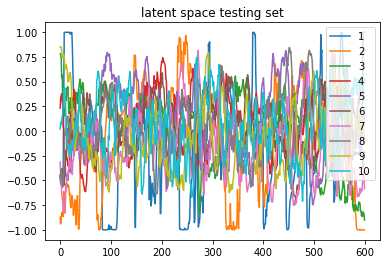

In [6]:
## latent space
print(latent_test.shape)
plt.figure()
for z in range(no_of_modes):
    plt.plot(latent_test[:,z],label=str(z+1))
plt.legend()
plt.title('latent space testing set')
plt.show()

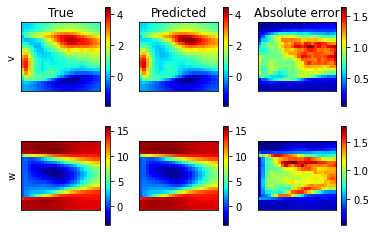

In [7]:
# autoencoder results
which_subnet = 9 # start from 0

myplot.plot_ae_results(u_test,y_test[which_subnet,:,:,:,:],u_avg,'mae')

In [67]:
## modes
modes_test = y_test - np.insert(y_test,0,np.zeros_like(y_test[0]),axis=0)[:no_of_modes,:,:,:,:]
print(modes_test.shape)
np.allclose(np.sum(modes_test,axis=0)[:,:,:,:],y_test[9,:,:,:,:],atol=0.00001)
# check if mode i = y_test_i - y_test_{i-1}
# for i in range(1,no_of_modes):
#     print(np.allclose(np.sum(modes_test[:i+1,:,:,:,:],axis=0),y_test[i,:,:,:,:],atol=0.00001))

(10, 600, 21, 24, 2)
True
True
True
True
True
True
True
True
True


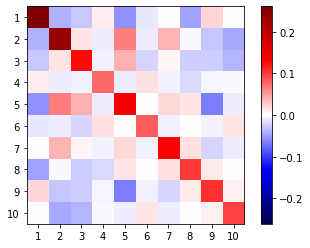

[ 1  2  5  7  3  9  8 10  6  4]
[ 5  2  1  3  9  8 10  7  6  4]


In [10]:
flatmodes = np.reshape(modes_test,[no_of_modes,-1])
cov = latent_test.T@latent_test/599
# cov = np.cov(latent_test.T)
# cov = np.cov(flatmodes)
# cov = np.corrcoef(flatmodes)
# cov = np.corrcoef(latent_test.T)
vmax = np.max(cov)
plt.figure()
plt.imshow(cov,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,no_of_modes+0.5,no_of_modes+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(1,no_of_modes+1))
plt.yticks(np.arange(1,no_of_modes+1))
plt.colorbar()
plt.show()
sort_idx = np.argsort(np.diag(cov))
rank_var = np.arange(1,no_of_modes+1)[np.flip(sort_idx)]
print(rank_var)

covar_sum = np.sum(np.abs(cov-np.diag(np.diag(cov))),axis=0)
sort_idx = np.argsort(covar_sum)
rank_cov = np.arange(1,no_of_modes+1)[np.flip(sort_idx)]
# print(covar_sum.shape)
print(rank_cov)

In [11]:
det = np.linalg.det(np.corrcoef(latent_test.T))
print('determinant of corr matrix: ',det) 
# det=1: completely uncorrelated 
# det=0: completely correlated

determinant of corr matrix:  0.21215721060934198


In [12]:
a = np.reshape(u_test,[600,-1]).T@np.reshape(u_test,[600,-1])
a = a/599
w,v = np.linalg.eigh(a)
print(np.flip(w[-10:]))

[270.8119   181.24873  102.3537    97.373116  82.65428   70.500336
  52.810165  40.856705  39.501484  33.20101 ]


In [ ]:
## plot time-averaged autoencoder mode
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

mode1_1 = ax1.imshow(np.mean(modes_test,axis=1)[0,:,:,0],'jet')
ax1.set_title("Mode 1, v")
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(mode1_1,ax=ax1)

mode1_2 = ax2.imshow(np.mean(modes_test,axis=1)[0,:,:,1],'jet')
ax2.set_title("Mode 1, w")
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(mode1_2,ax=ax2)

mode2_1 = ax3.imshow(np.mean(modes_test,axis=1)[1,:,:,0],'jet')
ax3.set_title("Mode 2, v")
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(mode2_1,ax=ax3)

mode2_2 = ax4.imshow(np.mean(modes_test,axis=1)[1,:,:,1],'jet')
ax4.set_title("Mode 2, w")
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(mode2_2,ax=ax4)
plt.suptitle("time-averaged autoencoder modes")

plt.show()

In [ ]:
## plt instantaneous modes
time = 0
fig,ax = plt.subplots(2,2)
plt.suptitle('modes at snapshot '+str(time))
    
mode1_v = ax[0,0].imshow(modes_test[0,time,:,:,0],'jet')
ax[0,0].set_title('Mode 1, v')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(mode1_v,ax=ax[0,0])

mode1_w = ax[0,1].imshow(modes_test[0,time,:,:,1],'jet')
ax[0,1].set_title('Mode 1, w')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(mode1_w,ax=ax[0,1])

mode2_v = ax[1,0].imshow(modes_test[1,time,:,:,0],'jet')
ax[1,0].set_title('Mode 2, v')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(mode2_v,ax=ax[1,0])

mode2_w = ax[1,1].imshow(modes_test[1,time,:,:,1],'jet')
ax[1,1].set_title('Mode 2, w')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(mode2_w,ax=ax[1,1])

plt.show()

In [ ]:
'''training curve'''
idx = np.where(hist_train == -1)[0]
idxval = np.where(hist_val == -1)[0]
plt.figure()
# plt.title('training loss')
plt.title('validation loss')
# plt.plot(hist_train[:idx[0]],label='subnet 1')
plt.plot(hist_val[:idx[0]],label='1')
for i in range(1,no_of_modes):
    label = 'subnet ' + str(i+1)
    # plt.plot(hist_train[idx[i-1]+1:idx[i]],label=label)
    plt.plot(hist_val[idx[i-1]+1:idx[i]],label=str(i+1))
plt.legend()
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()

## mode decomposition

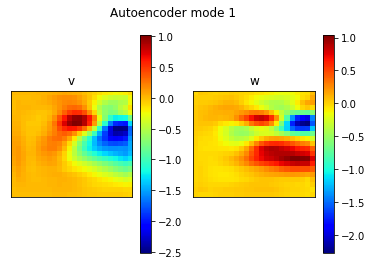

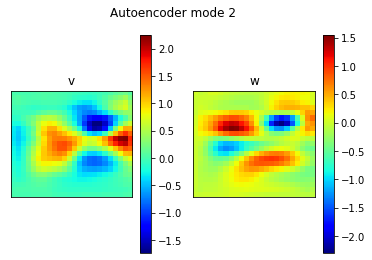

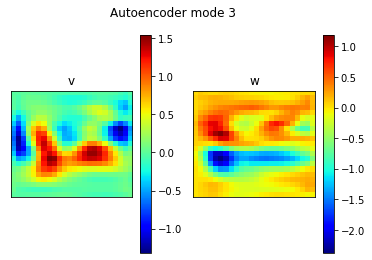

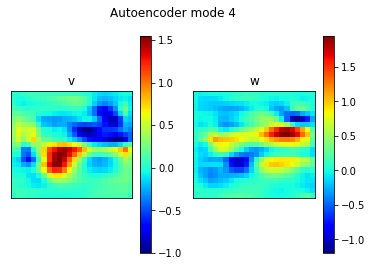

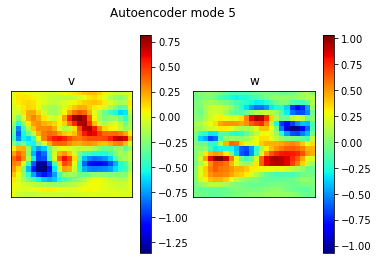

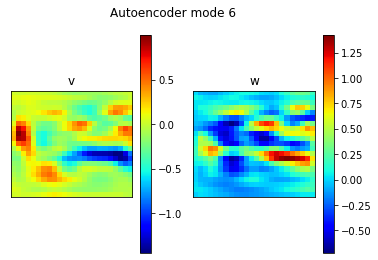

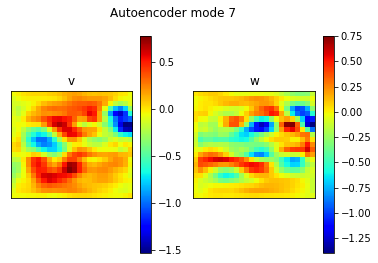

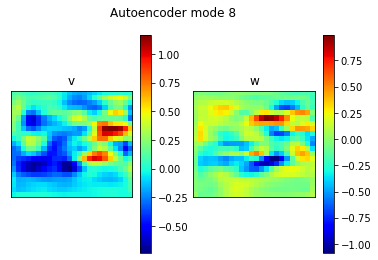

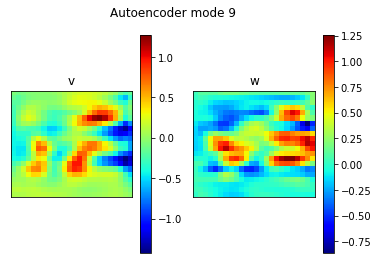

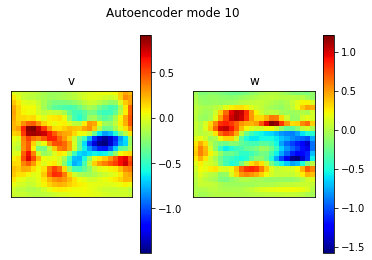

In [43]:
myplot.plot_ae_modes(modes_test,range(10),snapshot=0)

In [63]:
## build matrix
which_decoder = 2-1
vy = modes_test[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = modes_test[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
print(X.shape)

(42, 24, 600)


In [64]:
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean

# DMD
dmd = md.DMD(X[:,:,:-1],X[:,:,1:],r=50,keep_shape=True)
Phi,Lambda,b = dmd.get_modes()

# parameters
D       = 196.5;    # Model diameter in mm
Uinf    = 15;       # Nominal free stream velocity
fPIV    = 720;      # PIV sampling frequency
dt      = 1/fPIV;   # Delta t between image pairs

Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating DMD...
DMD done.


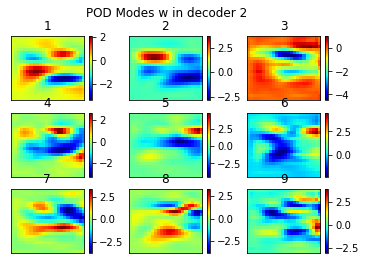

/home/ym917/anaconda3/envs/MD-CNN-AE/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


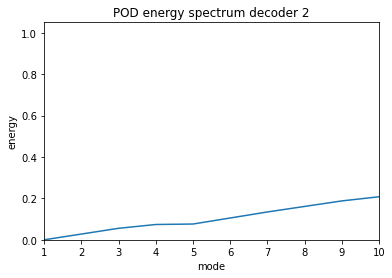

[3.7083286e-05-7.3640760e-14j 2.7776474e-02-1.3593312e-03j
 5.5515863e-02+0.0000000e+00j 7.3871121e-02-3.6450259e-11j
 7.6184496e-02-4.1044203e-11j]


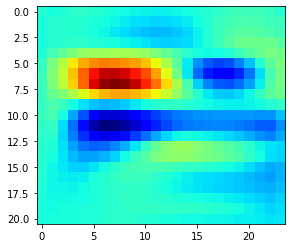

snapshot


In [66]:
## plot POD
PlotWhichVelocity = 'w' 
save_img = False

fig = plt.figure(1)
title = "POD Modes " + PlotWhichVelocity + " in decoder " + str(which_decoder+1)
# title = "POD Modes "+PlotWhichVelocity
plt.suptitle(title)
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    if PlotWhichVelocity == 'w': # Q was built [vz,vy]
        pltV = pltV[0:Ny,:]
    elif PlotWhichVelocity == 'v':
        pltV = pltV[Ny:,:]
    elif PlotWhichVelocity == 'V':
        pltV = (pltV[0:Ny,:]**2 + pltV[Ny:,:]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()
if save_img:
    p = folder + "POD_modes_" + str(which_decoder+1) + PlotWhichVelocity + ".png"
    plt.savefig(p)
else:
    plt.show()

## Spectrum
energy = np.cumsum(lam/np.sum(lam))
plt.figure()
title = 'POD energy spectrum decoder ' + str(which_decoder+1)
plt.title(title)
plt.plot(np.arange(len(energy))+1,energy)
plt.ylabel('energy')
plt.xlabel('mode')
plt.xlim([1,10])
plt.ylim([0,1.05])
if save_img:
    p = folder + "POD_spectrum_" + str(which_decoder+1) + ".png"
    plt.savefig(p)
else:
    plt.show()
print(energy[:5])

## Reconstruct
rebuildv = pod.reconstruct(number_of_modes=2,t=1,shape=[2,Ny,Nz])
if PlotWhichVelocity == 'w': # Q was built [vz,vy]
    rebuildv = rebuildv[0,:,:]
elif PlotWhichVelocity == 'v':
    rebuildv = rebuildv[1,:,:]
plt.figure()
plt.imshow(rebuildv.real,'jet')
plt.show()
print(pod.typePOD)

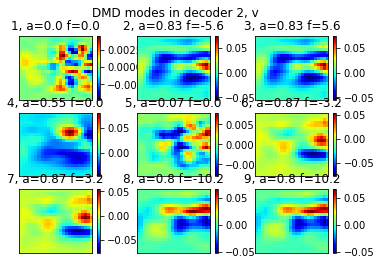

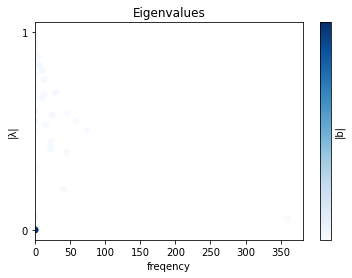

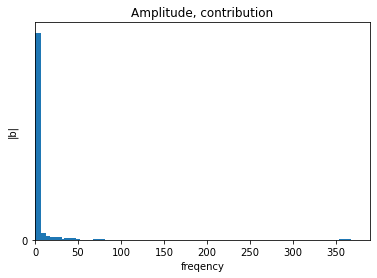

In [65]:
## plot DMD
mode_z = Phi[:Ny,:,:].real # X was built vstack(vz,vy)
mode_y = Phi[Ny:,:,:].real # has shape [ny,nz,modes]

whichmode = 0
whichvelocity = 'v'
save_img = False
# plot mean flow (b = 1.0)
# plt.figure()
# if whichvelocity == 'w':
#     plt.imshow(mode_z[:,:,whichmode],'jet')
# else:
#     plt.imshow(mode_y[:,:,whichmode],'jet')
# # plt.title('decoder '+str(WhichDecoder+1))
# plt.show()
# print(np.diag(Lambda)[whichmode])

plt.suptitle("DMD modes in decoder " + str(which_decoder+1) + ", " + whichvelocity)
# plt.suptitle("DMD modes "+ whichvelocity)
lam = np.diag(Lambda)
lam_r = np.abs(lam)
lam_f = np.angle(lam)/(2*np.pi)/dt
for i in range(9):
    title = str(i+1)+', a='+str(np.around(lam_r[i],decimals=2))+" f="+str(np.around(lam_f[i],1))
    ax = plt.subplot(3,3,i+1,title=title,xticks=[],yticks=[])
    if whichvelocity == 'w': # Q was built [vz,vy]
        pltV = mode_z[:,:,i]
    elif whichvelocity == 'v':
        pltV = mode_y[:,:,i]
    elif whichvelocity == 'V':
        pltV = (mode_z[:,:,i]**2 + mode_y[:,:,i]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()
if save_img:
    p = folder + "DMD_modes_" + str(which_decoder+1) + whichvelocity + ".png"
    plt.savefig(p)
else:
    plt.show()


## eigenvalue plot, temporal behaviour
lam_r, lam_f = dmd.get_frequency(dt)
b_r = dmd.get_amplitude()
plt.figure()
plt.scatter(lam_f,lam_r,c=b_r,cmap='Blues',vmin=0,vmax=max(b_r))
plt.colorbar(label='|b|',ticks=[])
plt.xlabel('freqency')
plt.ylabel('|λ|')
plt.title('Eigenvalues')
plt.yticks([0,1])
# plt.hlines(1,0,360,colors='k',linestyles='dotted')
plt.xlim(left=0)
plt.show()

# ## plot amplitude
max_fq = max(lam_f)
plt.figure()
# plt.plot(lam_f_sorted,b_r_sorted)
plt.bar(lam_f,b_r,width=700/dmd.r)
plt.xlabel('freqency')
plt.ylabel('|b|')
plt.title('Amplitude, contribution')
# plt.xticks([])
plt.xlim(left=0)
plt.yticks([0])
if save_img:
    p = folder + "DMD_amp_" + str(which_decoder+1) + ".png"
    plt.savefig(p)
else:
    plt.show()

In [18]:
# rankings (to compare with MD-CNN-AE)
import autoencoder_modes_selection as ranking

# signal
signal_energy = ranking.energy_freq(latent_test,remove_mean=True)
sort_idx = np.argsort(signal_energy)
rank_signal = np.arange(1,no_of_modes+1)[np.flip(sort_idx)]

# contribution
per_mode = ranking.percent_output(modes_test,y_test[-1,:,:,:,:])
sort_idx = np.argsort(np.abs(per_mode))
rank_con = np.arange(1,no_of_modes+1)[np.flip(sort_idx)]

# ke
ke = np.sum((modes_test**2),axis=(4,3,2,1))/(2*latent_test.shape[0])
sort_idx = np.argsort(ke)
rank_ke = np.arange(1,no_of_modes+1)[np.flip(sort_idx)]

# energy percentage (Eivazi 2022)
modes_E = np.copy(modes_test)
rank_en = np.zeros(no_of_modes,dtype='int')-1

for j in range(no_of_modes):
    E_ref = 0
    for i in range(no_of_modes):
        if i not in rank_en:
            E = 1-np.mean(np.sum((modes_E[i,:,:,:,:] - y_test[-1,:,:,:,:])**2,axis=(3,2,1))/np.sum(y_test[-1,:,:,:,:]**2,axis=(3,2,1)))
            if E > E_ref:
                E_ref = E
                rank_en[j] = i
    modes_E = modes_test + modes_E[rank_en[j]]
rank_en += 1

# mse loss
modes_E = np.copy(modes_test)
rank_mse = np.zeros(no_of_modes,dtype='int')-1
for j in range(no_of_modes):
    E_ref = 0
    for i in range(no_of_modes):
        if i not in rank_mse:
            E = 1/mse(u_test,modes_E[i]).numpy()
            if E > E_ref:
                E_ref = E
                rank_mse[j] = i
    modes_E = modes_test + modes_E[rank_mse[j]]
rank_mse += 1

In [51]:
i_mse = []
for i in range(no_of_modes):
    i_mse.append(mse(u_test,modes_test[i,:,:,:,:]).numpy())
sort_idx = np.argsort(i_mse)
rank_i_mse = np.arange(1,no_of_modes+1)[sort_idx]
print('rank_i_mse: ',rank_i_mse)

rank_i_mse:  [ 1  2  3  4  5  9  7 10  8  6]


In [19]:
# number of POD modes to reach 99.99% energy in the POD modes
to99 = np.zeros(no_of_modes,dtype='int')
for i in range(no_of_modes):
    vy = modes_test[i,:,:,:,0].astype('float64')
    vy = np.transpose(vy,[1,2,0])
    vz = modes_test[i,:,:,:,1].astype('float64')
    vz = np.transpose(vz,[1,2,0]) #(ny,nz,nt)
    X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
    pod = md.POD(X)
    Q_POD,lam = pod.get_modes()
    energy = np.cumsum(lam/np.sum(lam))
    for j in range(len(energy)):
        if energy[j] >= 0.9999:
            to99[i] = j+1
            break
print(to99)
sort_idx = np.argsort(to99)
rank_to99 = np.arange(1,no_of_modes+1)[np.flip(sort_idx)]
print(rank_to99)

Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating POD ...
Use snapshot POD, Nx > Nt.


/home/ym917/Documents/Codes/MD-CNN-AE/mode_decomposition.py:202: RuntimeWarning: invalid value encountered in sqrt
  Q_POD = (Q@Phi)*(1/(lam**0.5).T)


POD done.
Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
[  9  52 110 155 185 204 212 213 222 222]
[10  9  8  7  6  5  4  3  2  1]


## Linear

In [20]:
linear_modes = []

for i in range(no_of_modes):
    single = np.zeros_like(latent_test)
    single[:,i] = latent_test[:,i]
    linear_modes.append(last_decoder.predict(single))

linear_modes = np.array(linear_modes)

NameError: name 'last_decoder' is not defined

In [ ]:
# rankings (to compare with MD-CNN-AE)
import autoencoder_modes_selection as ranking

# signal
signal_energy = ranking.energy_freq(latent_test,remove_mean=True)
sort_idx = np.argsort(signal_energy)
rank_signal = np.arange(1,no_of_modes+1)[np.flip(sort_idx)]

# contribution
per_mode = ranking.percent_output(linear_modes,y_test[-1,:,:,:,:])
sort_idx = np.argsort(np.abs(per_mode))
rank_con = np.arange(1,no_of_modes+1)[np.flip(sort_idx)]

# ke
ke = np.sum((linear_modes**2),axis=(4,3,2,1))/(2*latent_test.shape[0])
sort_idx = np.argsort(ke)
rank_ke = np.arange(1,no_of_modes+1)[np.flip(sort_idx)]

# energy percentage (Eivazi 2022)
modes_E = np.copy(linear_modes)
rank_en = np.zeros(no_of_modes,dtype='int')-1

for j in range(no_of_modes):
    E_ref = 0
    for i in range(no_of_modes):
        if i not in rank_en:
            E = 1-np.mean(np.sum((modes_E[i,:,:,:,:] - y_test[-1,:,:,:,:])**2,axis=(3,2,1))/np.sum(y_test[-1,:,:,:,:]**2,axis=(3,2,1)))
            if E > E_ref:
                E_ref = E
                rank_en[j] = i
    modes_E = linear_modes + modes_E[rank_en[j]]
rank_en += 1

In [ ]:
modes_E = np.copy(linear_modes)
rank_en = np.zeros(no_of_modes,dtype='int')-1

for j in range(no_of_modes):
    E_ref = 0
    for i in range(no_of_modes):
        if i not in rank_en:
            E = 1-np.mean(np.sum((modes_E[i,:,:,:,:] - u_test)**2,axis=(3,2,1))/np.sum(u_test**2,axis=(3,2,1)))
            if E > E_ref:
                E_ref = E
                rank_en[j] = i
    modes_E = linear_modes + modes_E[rank_en[j]]
rank_en += 1

In [ ]:
# mse loss
modes_E = np.copy(modes_test)
rank_mse = np.zeros(no_of_modes,dtype='int')-1
for j in range(no_of_modes):
    E_ref = 0
    for i in range(no_of_modes):
        if i not in rank_mse:
            E = 1/mse(u_test,modes_E[i]).numpy()
            if E > E_ref:
                E_ref = E
                rank_mse[j] = i
    modes_E = modes_test + modes_E[rank_mse[j]]
rank_mse += 1
print(rank_mse)

In [ ]:
myplot.plot_ae_modes(linear_modes,range(10),snapshot=0)

In [ ]:
## build matrix
which_decoder = 9
PlotWhichVelocity = 'w' 
save_img = False
vy = linear_modes[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = linear_modes[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean
# parameters
D       = 196.5;    # Model diameter in mm
Uinf    = 15;       # Nominal free stream velocity
fPIV    = 720;      # PIV sampling frequency
dt      = 1/fPIV;   # Delta t between image pairs
## plot POD
fig = plt.figure(1)
title = "POD Modes " + PlotWhichVelocity + " in decoder " + str(which_decoder+1)
# title = "POD Modes "+PlotWhichVelocity
plt.suptitle(title)
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    if PlotWhichVelocity == 'w': # Q was built [vz,vy]
        pltV = pltV[0:Ny,:]
    elif PlotWhichVelocity == 'v':
        pltV = pltV[Ny:,:]
    elif PlotWhichVelocity == 'V':
        pltV = (pltV[0:Ny,:]**2 + pltV[Ny:,:]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()
if save_img:
    p = folder + "POD_modes_" + str(which_decoder+1) + PlotWhichVelocity + ".png"
    plt.savefig(p)
else:
    plt.show()

## Spectrum
energy = np.cumsum(lam/np.sum(lam))
print('spectrum (first 5): ', energy[:5])

In [21]:
print('contribution:   ',rank_con) # percentage contribution
print('kinetic energy: ',rank_ke) # kinetic energy
print('signal:         ',rank_signal) # signal
print('lambda_ae:      ',rank_var) # Z.T@Z, diagonal (variance)
print('covariance sum: ',rank_cov) # Z.T@Z antisymmetrix part sum of each row
# print('energy eivazi:  ',rank_en) # energy (Eivazi 2022)
print('mse:            ',rank_mse)

contriburion:    [ 2 10  1  3  5  4  7  6  9  8]
kinetic energy:  [ 1  2  3  8 10  9  7  5  4  6]
signal:          [ 1  2  5  3  7  9  8 10  4  6]
lambda_ae:       [ 1  2  5  7  3  9  8 10  6  4]
covariance sum:  [ 5  2  1  3  9  8 10  7  6  4]
mse:             [ 1  2  4  7  6  3  5  8  9 10]
